In [1]:
import matplotlib.pyplot as plt
import numpy as np
import camb
# from camb import model, initialpower
import emcee
from scipy import optimize

# I try to install camb on jupyter but it's fail.
# however I could install camb on my laptop. so, I use other programe to make code, and copy to jupyter.

ImportError: No module named camb

1. Investigate the change in the power spectrum with varying a cosmological parameter of your choice.

NameError: name 'camb' is not defined

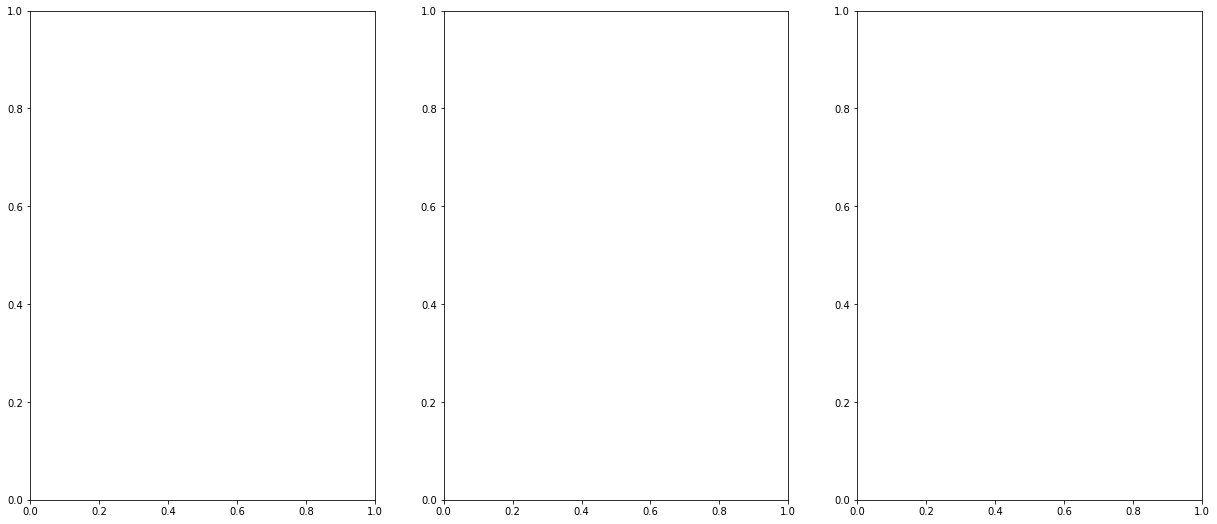

In [5]:

fig,ax = plt.subplots(1,3,figsize = (21,9))

for i,baryon,dm,curve in np.array([[0,0.0196,0.1176,0],[0,0.0196,0.2,0],[0,0.0196,0.3,0],[0,0.0196,0.4,0],[0,0.0196,0.5,0],\
    [1,0.0196,0.1176,0],[1,0.03,0.1176,0],[1,0.04,0.1176,0],[1,0.05,0.1176,0],[1,0.06,0.1176,0],\
        [2,0.0196,0.1176,0],[2,0.0196,0.1176,0.2],[2,0.0196,0.1176,0.4],[2,0.0196,0.1176,0.6],[2,0.0196,0.1176,0.8]]):

    pars = camb.CAMBparams()
    pars.set_cosmology(H0=70 ,ombh2=baryon ,omch2=dm ,omk=curve)
    pars.set_for_lmax(2500)

    results = camb.get_results(pars)

    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')

    totCL = powers['total']

    ls = np.arange(totCL.shape[0])

    ax[int(i)].plot(ls,totCL[:,0],label='H0=70 baryon={} DM={} curve={}'.format(baryon,dm,curve))
    ax[int(i)].legend(loc = 'upper right', fontsize = 8)

    ax[int(i)].set_ylabel("$\mu K^{2}$")
    ax[int(i)].set_xlabel("l")
plt.show()


# if curvature density changes, We can see that all of peak position to 'l' changes, first peak also moved by curvature density.
# so, from observation, we can compare the first peak position, and can define the parameter of curvature.
# if baryon density changes , we can see the change of second peak amplitude. 
# also, if DM density changes, we can clearly see the change in the ratio of the second and third peaks.

# even peaks shows minimum density, so baryon and DM density more larger make second peak lower.

2. measure chi2 for a cosmological model evaluated on the data.

In [3]:

a = open('wmap9.txt',"r")
a_line = a.readlines()[20:]

l = np.zeros(len(a_line))
data = np.zeros(len(a_line))
err = np.zeros(len(a_line))

for i,ii in enumerate(a_line):
    l[i] += float(ii.split()[0])
    data[i] += float(ii.split()[1])
    err[i] += float(ii.split()[2])
    

cov = np.diag(err**2)
icov = np.linalg.inv(cov)

def resi(theta,data,cov):
    phy_bar,phy_DM,curv = theta
    pars_d = camb.CAMBparams()
    # pars_d.set_cosmology(H0=70 ,ombh2=0.0196 ,omch2=0.1176 ,omk=0)
    pars_d.set_cosmology(H0=70 ,ombh2=phy_bar ,omch2=phy_DM ,omk=curv)
    pars_d.set_for_lmax(1200)
    results_d = camb.get_results(pars_d)
    powers_d =results_d.get_cmb_power_spectra(pars_d, CMB_unit='muK')
    model_d =powers_d['total'][1:1200,1]
    dy = model_d - data
    chi2 = dy.T @ cov @ dy
    return chi2

bounds = ((0,0.06),(0,0.6),(0,0.5))
args = (data ,icov)
res = optimize.differential_evolution(resi,bounds,args=args)

print(res)

# this code didn't work.
# It raise 'ThemoData Init: failed to find end of recombination' error, but I couldn't figure out why this error occured.
# there is same error on mcmc code too.

SyntaxError: invalid syntax (<ipython-input-3-a620f105d199>, line 28)

3. constrain cosmological parameters using MCMC etc.

In [4]:

def lnpi(theta):
    phy_bar,phy_DM,curv = theta
    if (0<phy_bar<0.06) and (0<phy_DM<0.5) and (-1<curv<1):
        return 0
    else:
        return -np.inf

def lnL(theta,data,icov):
    phy_bar,phy_DM,curv = theta
    pars_d = camb.CAMBparams()
    # pars_d.set_cosmology(H0=70 ,ombh2=0.0196 ,omch2=0.1176 ,omk=0)
    pars_d.set_cosmology(H0=70 ,ombh2=phy_bar ,omch2=phy_DM ,omk=curv)
    pars_d.set_for_lmax(1200)
    results_d = camb.get_results(pars_d)
    powers_d =results_d.get_cmb_power_spectra(pars_d, CMB_unit='muK')
    model_d =powers_d['total'][1:1200,1]
    dy = model_d - data
    chi2 = dy.T @ icov @ dy
    return -.5*chi2

def lnp(theta,data,icov):
    lp = lnpi(theta)
    if lp == -np.inf:
        return lp
    return lnL(theta,data,icov) + lp

ndim = 3
nwalkers = 10 
p0 = np.array([0.02,0.1,0]) + 1.e-1*np.random.randn(nwalkers,ndim)
niter = 2000
sampler = emcee.EnsembleSampler(nwalkers,ndim,lnp,args=(data,icov))
sampler.run_mcmc(p0,niter,progress=True)


fig,axes = plt.subplots(3,figsize=(12,7),sharex=True)
samples = sampler.get_chain()
labels = ["phy_bar","phy_DM","curve"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:,i],"k", alpha=0.3)

plt.show()

SyntaxError: invalid syntax (<ipython-input-4-cff2ba4b9ed5>, line 19)